In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain


import numpy as np 

from fomlads.data.external import import_for_classification
from fomlads.data.external import normalisation
from fomlads.plot.evaluations import plot_roc
from fomlads.plot.evaluations import plot_train_test_errors
from fomlads.evaluate.eval_classification import confusion_matrix
from fomlads.evaluate.eval_classification import misclassification_error
from fomlads.evaluate.eval_logistic import test_parameter_logistic
from fomlads.evaluate.eval_classification import false_true_rates
from fomlads.evaluate.eval_logistic import cross_validation

from fomlads.model.classification import logistic_regression_fit
from fomlads.model.classification import logistic_regression_predict
from fomlads.model.classification import logistic_regression_prediction_probs
from fomlads.model.classification import split_train_test

from sklearn.neighbors import KNeighborsClassifier
from fomlads.evaluate.eval_regression import root_mean_squared_error
from fomlads.evaluate.eval_classification import misclassification_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from fomlads.model.regression import construct_feature_mapping_approx
from fomlads.model.basis_functions import quadratic_feature_mapping
from fomlads.model.classification import logistic_regression_fit
from fomlads.model.classification import logistic_regression_prediction_probs


In [10]:

def fit_and_plot_roc_confusion_matrix_logistic_regression(
        inputs, targets, fig_ax=None, colour=None):
    """
    Takes input and target data for classification and fits shared covariance
    model. Then plots the ROC corresponding to the fit model.
    parameters
    ----------
    inputs - a 2d input matrix (array-like), each row is a data-point
    targets - 1d target vector (array-like) -- can be at most 2 classes ids
        0 and 1
    """
    weights = logistic_regression_fit(inputs, targets)
    #
    thresholds = np.linspace(0,1.5,1000)
    
    false_positive_rates, true_positive_rates = false_true_rates(inputs, targets, weights, thresholds)

    fig1, ax1 = plot_roc(
        false_positive_rates, true_positive_rates, fig_ax=fig_ax, colour=colour)


    # and for the class prior we learnt from the model
    num_neg = np.sum(1-targets)
    num_pos = np.sum(targets)
    predicts = logistic_regression_predict(inputs, weights)
    fpr = np.sum((predicts == 1) & (targets == 0))/num_neg
    tpr = np.sum((predicts == 1) & (targets == 1))/num_pos
    ax1.plot([fpr], [tpr], 'rx', markersize=8, markeredgewidth=2)

    #Confusion matrix
    fig2, ax2 = confusion_matrix(targets, predicts)
    return (fig1, fig2), (ax1, ax2)


def test_parameter_knn(train_inputs, train_targets, test_inputs, test_targets, n_neighbors=3, parameter_values= np.linspace(0, 2), parameter_name = 'Threshold'):
    """ 
    train_inputs
    train_targets
    test_inputs
    train_inputs


    return
    ----- 
    plot of test/train error according to the parameter tested
    """
    
    train_errors = []
    test_errors = []

    for reg_param in parameter_values:
        
        model = KNeighborsClassifier(n_neighbors=20)
        model.fit(train_inputs,train_targets)

        #get preduction for both data sets
        prediction_probs_train = model.predict_proba(train_inputs)[:,1]
        prediction_probs_test = model.predict_proba(test_inputs)[:,1]

        print(prediction_probs_train.shape,prediction_probs_test.shape)
        
        predicts_train = (prediction_probs_train > reg_param).astype(int)
        predicts_test = (prediction_probs_test > reg_param).astype(int)

        #Get the errors for both data sets
        train_error = misclassification_error(train_targets, predicts_train)
        test_error =  misclassification_error(test_targets, predicts_test)
        
        train_errors.append(train_error)
        test_errors.append(test_error)
    
    return train_errors, test_errors

In [3]:
# def test_parameter_logistic(train_inputs, train_targets, test_inputs, test_targets, parameter_values= np.linspace(0, 2), parameter_name = 'Threshold'):
#     """ 
#     train_inputs
#     train_targets
#     test_inputs
#     train_inputs


#     return
#     ----- 
#     plot of test/train error according to the parameter tested
#     """
    
#     train_errors = []
#     test_errors = []

#     for reg_param in parameter_values:
#             ## Calculate wieghts on the training data 
#         weights = logistic_regression_fit(train_inputs, train_targets)
        
#             #get preduction for both data sets
#         prediction_probs_train = logistic_regression_prediction_probs(train_inputs, weights)
#         prediction_probs_test = logistic_regression_prediction_probs(test_inputs, weights)

#         print(prediction_probs_train.shape,prediction_probs_test.shape)
#         predicts_train = (prediction_probs_train > reg_param).astype(int)
#         predicts_test = (prediction_probs_test > reg_param).astype(int)

#             #Get the errors for both data sets
#         train_error = misclassification_error(train_targets, predicts_train)
#         test_error =  misclassification_error(test_targets, predicts_test)
#         train_errors.append(train_error)
#         test_errors.append(test_error)
    
#     return train_errors, test_errors


In [11]:
#Read the file and clean the data
churn_data = pd.read_csv('Churn_Modelling.csv')
word_label = ['Geography', 'Gender']
removing = []

for column in word_label:
    if(churn_data[column].dtype == np.str or churn_data[column].dtype == np.object):
        for cat in churn_data[column].unique():
            churn_data[column+'_'+cat] = np.where(churn_data[column] == cat, 1, 0)
        removing.append(column)
churn_data = churn_data.drop(removing, axis = 1)

churn_data = churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis =1)

In [12]:
churn_data.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0


Confusion matrix, without normalization
[[7755.  208.]
 [1892.  145.]]


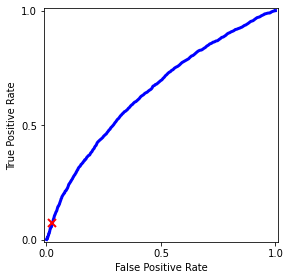

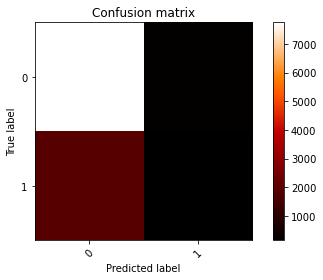

In [13]:
#Normalise the data for the logistic regression 
need_normalization = [ 'CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary']
churn_data[need_normalization] = normalisation(churn_data[need_normalization])

#Define inputs and targets in the dataframe
inputs= churn_data[['CreditScore', 'Age', 'Tenure','Balance','NumOfProducts', 'EstimatedSalary']].to_numpy()
targets = churn_data['Exited'].to_numpy()

#fit the data
# Plot the corresponding ROC 
# Plot the confusion matrix
fig_ax = fit_and_plot_roc_confusion_matrix_logistic_regression(inputs, targets, colour = 'b')

In [14]:
#Split the dataset into test and train sets
train_set, test_set = split_train_test(churn_data, test_ratio= 0.2)

#Define inputs and outputs for both sets:
train_inputs = train_set[['CreditScore', 'Age', 'Tenure','Balance','NumOfProducts', 'EstimatedSalary']].to_numpy()
train_targets = train_set['Exited'].to_numpy()
test_inputs = test_set[['CreditScore', 'Age', 'Tenure','Balance','NumOfProducts', 'EstimatedSalary']].to_numpy()
test_targets = test_set['Exited'].to_numpy()

In [17]:
# #Get the test and train errors 
# reg_params = np.linspace(0, 2)
# train_errors, test_errors = test_parameter_logistic(train_inputs, train_targets, test_inputs, test_targets, parameter_values= reg_params)
# #Plot the test and train errors 
# plot_train_test_errors('Threshold', reg_params, train_errors, test_errors)

# plt.show()



In [15]:
reg_params = np.linspace(0, 2)
#train_errors, test_errors = test_parameter_knn(train_inputs, train_targets,test_inputs,test_targets,10, reg_params)

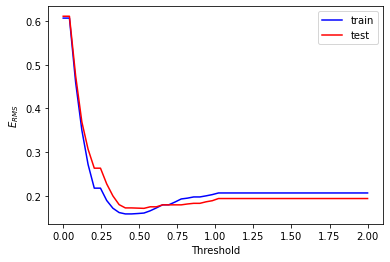

In [16]:
plot_train_test_errors('Threshold', reg_params, train_errors, test_errors)

plt.show()